# Training a baseline neural network with standard BCE loss #

### This notebook focuses on training a neural network using PyTorch's standard binary cross-entropy loss for neural network classification tasks for high energy particle physics. ###

#### Dataset preprocessing ####

Datasets are sourced from Kaggle's Higgs Boson Machine Learning Challenge from 2014. The files are as follows:
- train.csv
- test.csv
- random_submission.csv

For this project, the training.csv file is utilized for hyperparameter and training time optimization and fully used for training the final model. The test.csv file is used to create the submission predictions for evaluating the final model. The random_submission.csv file provides an example file format for submission.

Files are read through NumPy's read_csv() function and translated to NumPy dataframes. Missing values are fixed through mean imputation. Since the distributions of the features are approximately normal, no significant skewness is caused through mean imputation. Median imputation is also an option.

These cells should be run for dataset preprocessing.

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("data/training/training.csv")
test_df = pd.read_csv("data/test/test.csv")

print(train_df.shape)
train_df.head()

(250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [6]:
train_df.replace(-999.0, pd.NA, inplace=True)
test_df.replace(-999.0, pd.NA, inplace=True)

train_df.fillna(train_df.mean(numeric_only=True), inplace=True)
test_df.fillna(test_df.mean(numeric_only=True), inplace=True)

train_df.dropna(axis=1, thresh=int(0.9 * len(train_df)), inplace=True)
test_df.dropna(axis=1, thresh=int(0.9 * len(test_df)), inplace=True)

In [7]:
train_df["Label"] = train_df["Label"].str.strip().str.lower()
train_df["Label"] = train_df["Label"].map({'s': 1, 'b': 0})

feature_cols = [col for col in train_df.columns if col.startswith("DER_") or col.startswith("PRI_")]

X_test = test_df[feature_cols]

#### Initial training and hyperparameter optimization with Optuna ####

Initial model training and hyperparameter optimization is done simultaneously using the Optuna library. The hyperparameters being tuned are:
- n_layers
- hidden_size
- dropout_rate
- lr
- batch_size

The dataset is split using stratified k-fold cross validation. For the initial training, k=3 for faster processing and quicker optimization of the hyperparameter optimization. Each trial is optimized to achieve a better average AUC-ROC score across the 3 folds.

At the end of the run, the best trial is given with its AUC-ROC score average and the optimal parameters.

These cells only need to be run in order to see the optimized hyperparameter values. Since Optuna is running with 50 trials, the cell will take some hours to finish running.

In [9]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

X = train_df[feature_cols].values
y = train_df["Label"].values

def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_size = trial.suggest_int("hidden_size", 64, 512, step=64)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_scores = []

    for train_idx, val_idx in skf.split(X, y):
        # Split and scale
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Build dynamic model
        layers = []
        input_size = X.shape[1]
        for _ in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, 1))
        layers.append(nn.Sigmoid())
        model = nn.Sequential(*layers)

        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train
        model.train()
        for epoch in range(10):  # Keep epochs small for tuning speed
            for xb, yb in train_loader:
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # Evaluate on validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor).numpy().flatten()
        val_score = roc_auc_score(y_val, val_preds)
        val_scores.append(val_score)

    return sum(val_scores) / len(val_scores)  # average AUC across folds

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)

C:\Users\visha\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-16 11:29:49,007] A new study created in memory with name: no-name-c602ca48-534f-4153-b48c-fafb757485dc
[I 2025-06-16 11:33:41,473] Trial 0 finished with value: 0.899762731388109 and parameters: {'n_layers': 4, 'hidden_size': 320, 'dropout': 0.21194796337282384, 'lr': 0.004000424740648648, 'batch_size': 256}. Best is trial 0 with value: 0.899762731388109.
[I 2025-06-16 11:37:59,582] Trial 1 finished with value: 0.901588641187787 and parameters: {'n_layers': 3, 'hidden_size': 512, 'dropout': 0.15832570431961082, 'lr': 0.00012049334135141422, 'batch_size': 256}. Best is trial 1 with value: 0.901588641187787.
[I 2025-06-16 11:42:09,876] Trial 2 finished with value: 0.900277512417445 and parameters: {'n_layers': 5, 'h

Best trial:
{'n_layers': 5, 'hidden_size': 384, 'dropout': 0.2563994979733446, 'lr': 0.00026724473332425096, 'batch_size': 64}


#### Final testing of model ####

The final testing of the model is done through stratified k-fold cross validation with k=3, using the optimized hyperparameters from Optuna. The number of folds was set to 3 in order to provide valid comparison to the AMS based model. Since 3 models are being trained, 3 metrics are calculated for each model and averaged at the end. The 3 metrics are:
- Area under the receiver operating characteristic curve (AUC-ROC)
- Accuracy
- Approximate median significance (AMS)

Furthermore, the graphs of loss vs. time(epochs) is graphed in order to check for overfitting. After several reruns, the optimal amount of time was determined to be 10 epochs.

These cells should be run for testing optimized hyperparameters, which have already been entered in. For testing of different hyperparameters, change the best_params dictionary to contain the different values.

In [9]:
y = train_df["Label"].values.reshape(-1,1)

best_params = {
    'n_layers': 5,
    'hidden_size': 384,
    'dropout': 0.2563994979733446,
    'lr': 0.00026724473332425096,
    'batch_size': 64
}

In [6]:
auc_scores = []
acc_scores = []
ams_scores = []

In [7]:
def ams_score(y_true, y_pred, weights, b_reg=10.0):
            y_true = y_true.flatten()
            y_pred = y_pred.flatten()
            s = weights[(y_true == 1) & (y_pred == 1)].sum()
            b = weights[(y_true == 0) & (y_pred == 1)].sum()
            return np.sqrt(2 * ((s + b + b_reg) * np.log(1 + s / (b + b_reg)) - s))

Fold 1/3
Epoch 1: Loss = 0.4286, Val AMS = 1.5802, AUC-ROC = 0.8921, Accuracy = 0.8245
Epoch 2: Loss = 0.3821, Val AMS = 1.6134, AUC-ROC = 0.8997, Accuracy = 0.8306
Epoch 3: Loss = 0.3752, Val AMS = 1.6266, AUC-ROC = 0.8998, Accuracy = 0.8299
Epoch 4: Loss = 0.3709, Val AMS = 1.5770, AUC-ROC = 0.9004, Accuracy = 0.8306
Epoch 5: Loss = 0.3679, Val AMS = 1.6426, AUC-ROC = 0.9020, Accuracy = 0.8325
Epoch 6: Loss = 0.3651, Val AMS = 1.5947, AUC-ROC = 0.9021, Accuracy = 0.8320
Epoch 7: Loss = 0.3626, Val AMS = 1.6151, AUC-ROC = 0.9017, Accuracy = 0.8329
Epoch 8: Loss = 0.3606, Val AMS = 1.6313, AUC-ROC = 0.8996, Accuracy = 0.8313
Epoch 9: Loss = 0.3578, Val AMS = 1.5738, AUC-ROC = 0.9019, Accuracy = 0.8309
Epoch 10: Loss = 0.3553, Val AMS = 1.5838, AUC-ROC = 0.9018, Accuracy = 0.8314


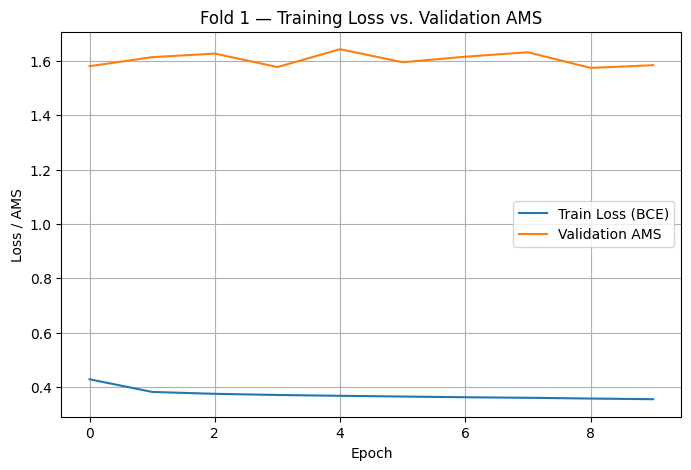

Fold 2/3
Epoch 1: Loss = 0.4302, Val AMS = 1.6138, AUC-ROC = 0.8934, Accuracy = 0.8224
Epoch 2: Loss = 0.3820, Val AMS = 1.5114, AUC-ROC = 0.8980, Accuracy = 0.8266
Epoch 3: Loss = 0.3755, Val AMS = 1.5997, AUC-ROC = 0.9003, Accuracy = 0.8309
Epoch 4: Loss = 0.3711, Val AMS = 1.6205, AUC-ROC = 0.9012, Accuracy = 0.8304
Epoch 5: Loss = 0.3673, Val AMS = 1.5938, AUC-ROC = 0.9006, Accuracy = 0.8307
Epoch 6: Loss = 0.3646, Val AMS = 1.5786, AUC-ROC = 0.9015, Accuracy = 0.8300
Epoch 7: Loss = 0.3616, Val AMS = 1.6082, AUC-ROC = 0.9026, Accuracy = 0.8323
Epoch 8: Loss = 0.3593, Val AMS = 1.5604, AUC-ROC = 0.9016, Accuracy = 0.8306
Epoch 9: Loss = 0.3567, Val AMS = 1.5733, AUC-ROC = 0.9009, Accuracy = 0.8296
Epoch 10: Loss = 0.3538, Val AMS = 1.5274, AUC-ROC = 0.9006, Accuracy = 0.8303


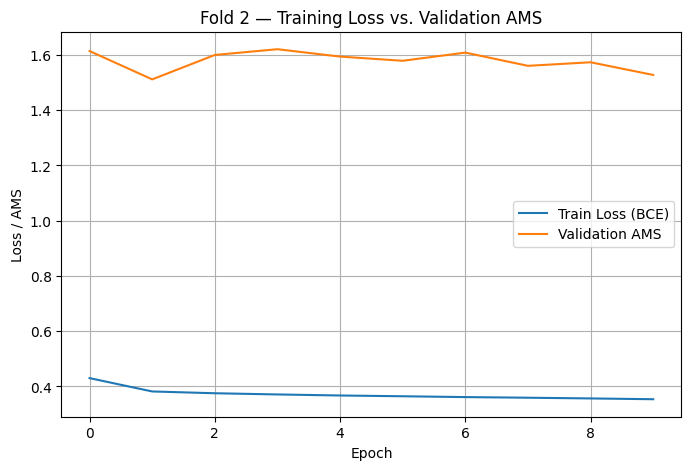

Fold 3/3
Epoch 1: Loss = 0.4301, Val AMS = 1.6148, AUC-ROC = 0.8931, Accuracy = 0.8245
Epoch 2: Loss = 0.3828, Val AMS = 1.6528, AUC-ROC = 0.8985, Accuracy = 0.8288
Epoch 3: Loss = 0.3754, Val AMS = 1.6416, AUC-ROC = 0.9017, Accuracy = 0.8317
Epoch 4: Loss = 0.3710, Val AMS = 1.5674, AUC-ROC = 0.9016, Accuracy = 0.8315
Epoch 5: Loss = 0.3677, Val AMS = 1.6050, AUC-ROC = 0.9003, Accuracy = 0.8316
Epoch 6: Loss = 0.3647, Val AMS = 1.6014, AUC-ROC = 0.9006, Accuracy = 0.8304
Epoch 7: Loss = 0.3622, Val AMS = 1.6319, AUC-ROC = 0.9023, Accuracy = 0.8331
Epoch 8: Loss = 0.3596, Val AMS = 1.6505, AUC-ROC = 0.9012, Accuracy = 0.8298
Epoch 9: Loss = 0.3568, Val AMS = 1.5998, AUC-ROC = 0.9013, Accuracy = 0.8303
Epoch 10: Loss = 0.3538, Val AMS = 1.5467, AUC-ROC = 0.9001, Accuracy = 0.8308


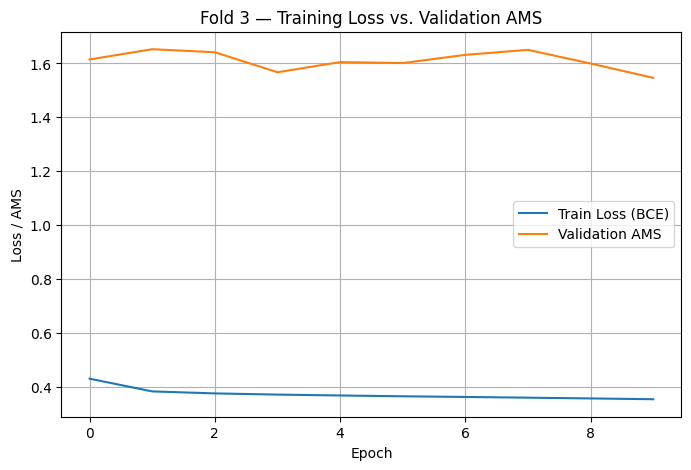

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold_aucs = []

X = train_df[feature_cols].values
y = train_df["Label"].values

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.ravel())):
    print(f"Fold {fold+1}/3")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size = best_params['batch_size'], shuffle = True)

    input_size = X.shape[1]
    layers = []
    for _ in range(best_params['n_layers']):
        layers.append(nn.Linear(input_size, best_params['hidden_size']))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(best_params['dropout']))
        input_size = best_params['hidden_size']
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = best_params['lr'])

    train_losses = []
    current_fold_ams_vals = []

    model.train()
    for epoch in range(10):
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        with torch.no_grad():
            # Predict probabilities and binary classes
            val_probs = model(X_val_tensor).numpy().flatten()
            val_preds = (val_probs > 0.5).astype(int)  # adjust threshold if needed

        # AUC
        auc = roc_auc_score(y_val, val_probs)
        
        # Accuracy
        acc = accuracy_score(y_val, val_preds)
    
        w_val = train_df["Weight"].values[val_idx].reshape(-1, 1)
        ams = ams_score(y_val, val_preds, w_val)
    
        train_losses.append(epoch_loss / len(train_loader))
        current_fold_ams_vals.append(ams)
        
        auc_scores.append(auc)
        acc_scores.append(acc)
        ams_scores.append(ams)

        print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Val AMS = {ams:.4f}, AUC-ROC = {auc:.4f}, Accuracy = {acc:.4f}")
        
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss (BCE)")
    plt.plot(current_fold_ams_vals, label="Validation AMS")
    plt.title(f"Fold {fold+1} — Training Loss vs. Validation AMS")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / AMS")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
print(f"\nFinal 3-Fold Metrics:")
print(f"Average AUC: {np.mean(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average AMS: {np.mean(ams_scores):.4f}")


Final 3-Fold Metrics:
Average AUC: 0.8992
Average Accuracy: 0.8296
Average AMS: 1.5865


#### Final Submission Model ####

In these cells, a final model is trained on the entire training.csv dataset using the optimal hyperparameters from Optuna and also the optimal training time from the tests above.

During the training, loss is printed next to the corresponding epoch to check for any severe variations.

Finally, the model is used to create predictions on test.csv. These predictions are then submitted to Kaggle after creating a .csv file in the format provided in random_submission. The submission includes 3 columns:
- Event ID
- Rank Order (in terms of event significance)
- Label ('s' or 'b' for signal or background events)

The final submission to Kaggle yielded an AMS score of: 2.78876

In [14]:
# Prepare training data
X_full = train_df[feature_cols].values
y_full = train_df["Label"].values.reshape(-1, 1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_full, dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Build model
input_size = X_tensor.shape[1]
layers = []
for _ in range(best_params['n_layers']):
    layers.append(nn.Linear(input_size, best_params['hidden_size']))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(best_params['dropout']))
    input_size = best_params['hidden_size']
layers.append(nn.Linear(input_size, 1))
layers.append(nn.Sigmoid())
final_model_bce = nn.Sequential(*layers)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(final_model_bce.parameters(), lr=best_params['lr'])

# Train model
epochs = 10
final_model_bce.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = final_model_bce(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - BCE Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/10 - BCE Loss: 0.4210
Epoch 2/10 - BCE Loss: 0.3937
Epoch 3/10 - BCE Loss: 0.3881
Epoch 4/10 - BCE Loss: 0.3838
Epoch 5/10 - BCE Loss: 0.3804
Epoch 6/10 - BCE Loss: 0.3790
Epoch 7/10 - BCE Loss: 0.3777
Epoch 8/10 - BCE Loss: 0.3758
Epoch 9/10 - BCE Loss: 0.3752
Epoch 10/10 - BCE Loss: 0.3738


In [15]:
X_test_scaled = scaler.transform(X_test.values)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [17]:
model.eval()
with torch.no_grad():
    test_probs = final_model_bce(X_test_tensor).numpy().flatten()

In [18]:
test_df["prob"] = test_probs
test_df["RankOrder"] = test_df["prob"].rank(method='first', ascending=False).astype(int)
test_df["Class"] = np.where(test_df["prob"] > 0.5, 's', 'b')

submission_df = test_df[["EventId", "RankOrder", "Class"]]
submission_df.to_csv("submission_bce.csv", index=False)

#### Exporting Prediction for Significance Test ####

To compare this standard BCE-loss model to the AMS-loss model, we need a set of predictions that can be evaluated. Since the previously generated dataset for Kaggle cannot be evaluated locally, significance testing is not possible.

To bypass this, we will use stratified k-fold cross validation to allow for prediction evaluation. We will run this with 3 folds and then export the results in a .csv file for analysis in a different notebook.

In [11]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

X = train_df[feature_cols].values
y = train_df["Label"].values.reshape(-1, 1)
w = train_df["Weight"].values.reshape(-1, 1)

# For output
all_preds, all_true, all_weights, all_folds = [], [], [], []

k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y.ravel())):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    w_train, w_val = w[train_idx], w[val_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

    input_size = X_train.shape[1]
    layers = []
    for _ in range(best_params["n_layers"]):
        layers.append(nn.Linear(input_size, best_params["hidden_size"]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(best_params["dropout"]))
        input_size = best_params["hidden_size"]
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
    criterion = nn.BCELoss()

    model.train()
    for epoch in range(10):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        val_probs = model(X_val_tensor).numpy().flatten()

    all_preds.extend(val_probs)
    all_true.extend(y_val.flatten())
    all_weights.extend(w_val.flatten())
    all_folds.extend([fold] * len(y_val))

# Save results
bce_preds_df = pd.DataFrame({
    "fold": all_folds,
    "true_label": all_true,
    "weight": all_weights,
    "pred_prob": all_preds
})

bce_preds_df.to_csv("bce_preds.csv", index=False)